[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)

In [7]:
import os
# os.environ['NUMBA_NUM_THREADS'] = '10'
os.environ['NUMBA_NUM_THREADS']

KeyError: 'NUMBA_NUM_THREADS'

In [8]:
os.environ['DEFAULT_NUMBA_NUM_THREADS']

KeyError: 'DEFAULT_NUMBA_NUM_THREADS'

In [5]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
#     pip_install_on_colab('PySDM-examples')

In [6]:
import os
import sys
from datetime import datetime
import json
from PySDM.physics import si
from PySDM_examples.Srivastava_1982 import coalescence_and_breakup_eq13, Settings
from open_atmos_jupyter_utils import show_plot

import numpy as np
from matplotlib import pyplot
from PySDM_examples.Srivastava_1982.simulation import Simulation
import numba

from PySDM.products import SuperDropletCountPerGridbox, VolumeFirstMoment, ZerothMoment
from PySDM.backends import GPU, CPU
from PySDM.dynamics import Collision
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import ConstantSize
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.collision_kernels import ConstantK

In [4]:
MY_SETUP_INFO_FILENAME="my_local_cpu_env_info"
import os
assert not os.path.isfile(MY_SETUP_INFO_FILENAME)

!echo NUMBA_DEFAULT_NUM_THREADS: $numba.config.NUMBA_DEFAULT_NUM_THREADS >> $MY_SETUP_INFO_FILENAME
!echo NUMBA_NUM_THREADS: $numba.config.NUMBA_NUM_THREADS >> $MY_SETUP_INFO_FILENAME
!lscpu >> $MY_SETUP_INFO_FILENAME
!nvidia-smi >> $MY_SETUP_INFO_FILENAME

!cat /proc/cpuinfo >> $MY_SETUP_INFO_FILENAME

AssertionError: 

In [9]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [10]:
dt = 1 * si.s
dv = 1 * si.m**3
drop_mass_0=1 * si.g
total_number=1e12

NO_BOUNCE = ConstEb(1)

TIMESTAMP = None

In [11]:
class ProductsNames:
  super_particle_count = "super_particle_count"
  total_volume="total_volume"
  total_number="total_number"


def setup_simulation(settings, n_sd, seed):


  products=(
      SuperDropletCountPerGridbox(
          name=ProductsNames.super_particle_count
      ),
      VolumeFirstMoment(name=ProductsNames.total_volume),
      ZerothMoment(name=ProductsNames.total_number)
  )

  collision_rate = settings.srivastava_c + settings.srivastava_beta
  simulation = Simulation(
      n_steps=None,
      settings=settings,
      collision_dynamic=Collision(
          collision_kernel=ConstantK(a=collision_rate),
          coalescence_efficiency=ConstEc(settings.srivastava_c / collision_rate),
          breakup_efficiency=NO_BOUNCE,
          fragmentation_function=ConstantSize(c=settings.frag_mass / settings.rho),
          warn_overflows=False,
          adaptive=False
      ),
      double_precision=True,
  )
  particulator = simulation.build(n_sd, seed, products=products)

  return particulator

In [12]:
def setup_coalescence_only_sim(n_sd, backend_class, seed):

  title = "fig_coalescence-only"
  c = 0.5e-6 / si.s
  beta = 1e-15 / si.s
  frag_mass = -1 * si.g

  settings = Settings(
      srivastava_c=c,
      srivastava_beta=beta,
      frag_mass=frag_mass,
      drop_mass_0=drop_mass_0,
      dt=dt,
      dv=dv,
      n_sds=(),
      total_number=total_number,
      backend_class=backend_class,
  )

  return setup_simulation(settings, n_sd, seed)

In [13]:
def setup_breakup_only_sim(n_sd, backend_class, seed):
  title = "fig_breakup-only"
  c =  1e-15 / si.s
  beta = 1e-9 / si.s
  frag_mass = 0.25 * si.g

  settings = Settings(
      srivastava_c=c,
      srivastava_beta=beta,
      frag_mass=frag_mass,
      drop_mass_0=drop_mass_0,
      dt=dt,
      dv=dv,
      n_sds=(),
      total_number=total_number,
      backend_class=backend_class,
  )
  return setup_simulation(settings, n_sd, seed)

In [14]:
def setup_coalescence_breakup_sim(n_sd, backend_class, seed):
  title = "fig_coalescence-breakup"
  c =  0.5e-6 / si.s
  beta = 1e-9 / si.s
  frag_mass = 0.25 * si.g

  settings = Settings(
      srivastava_c=c,
      srivastava_beta=beta,
      frag_mass=frag_mass,
      drop_mass_0=drop_mass_0,
      dt=dt,
      dv=dv,
      n_sds=(),
      total_number=total_number,
      backend_class=backend_class,
  )
  return setup_simulation(settings, n_sd, seed)

In [15]:
TIMESTAMP = str(datetime.now())

Benchmark function

In [16]:
import time

def print_all_products(particulator):
  print(ProductsNames.total_number, particulator.products[ProductsNames.total_number].get())
  print(ProductsNames.total_volume, particulator.products[ProductsNames.total_volume].get())
  print(ProductsNames.super_particle_count, particulator.products[ProductsNames.super_particle_count].get())


def go_benchmark(setup_sim, n_sds, n_steps, seeds, numba_n_threads=[None], backends=[CPU, GPU]):
  dt = datetime.now()
  TIMESTAMP = str(dt)

  results = {}

  cpu_backends_configs = [(CPU, i) for i in numba_n_threads]
  backend_configs = []
  if CPU in backends:
    backend_configs = [*backend_configs, *cpu_backends_configs]
  if GPU in backends:
    backend_configs.append((GPU, None))

  for backend_class, n_threads in backend_configs:
    backend_name = backend_class.__name__
    if n_threads:
      numba.set_num_threads(n_threads)
      backend_name += "_" + str(numba.get_num_threads())
      

    results[backend_name] = {}

    print('\n', 'before')

    for n_sd in n_sds:
      print()
      print(backend_name, n_sd)
      print()
      results[backend_name][n_sd] = {}

      for seed in seeds:
        particulator = setup_sim(n_sd, backend_class, seed)
        particulator.run(steps=1)

        t0 = time.time()
        particulator.run(steps=n_steps)
        t1 = time.time()

        elapsed_time_per_timestep = (t1 - t0) / n_steps

        print('\n', 'after')
        print_all_products(particulator)

        results[backend_name][n_sd][seed] = elapsed_time_per_timestep

  return results


In [13]:
def process_results(res_d):
  processed_d = {}
  for backend in res_d.keys():
    processed_d[backend] = {}

    for n_sd in res_d[backend].keys():
      processed_d[backend][n_sd] = {}

      vals = res_d[backend][n_sd].values()
      vals = np.array(list(vals))

      processed_d[backend][n_sd]['mean'] = np.mean(vals)
      processed_d[backend][n_sd]['std'] = np.std(vals)
      processed_d[backend][n_sd]['max'] = np.amax(vals)
      processed_d[backend][n_sd]['min'] = np.amin(vals)

  return processed_d

In [103]:
def write_to_file(filename, d):
  assert not os.path.isfile(filename)

  with open(filename, "w") as fp:
    json.dump(d, fp)


def plot_processed_results(processed_d, show=True, plot_label='', plot_title=None, metric='min'):
  x = []
  y = []

  backends = list(processed_d.keys())
  backends.sort()
  backends.sort(key=lambda x: int(x[6:]) if 'Numba_' in x else 100**10)

  markers = {backend: 'o' if 'Numba' in backend else 'x' for backend in backends}

  for backend in backends:
    for n_sd in processed_d[backend].keys():
      if n_sd not in x:
        x.append(n_sd)

  x.sort()

  for backend in backends:
    y = []
    for n_sd in x:
      v = processed_d[backend][n_sd][metric]
      y.append(v)

    pyplot.plot(x, y, label=backend+plot_label, marker=markers[backend])

  pyplot.legend(bbox_to_anchor =(1.1, 1))
  pyplot.xscale('log', base=2)
  pyplot.yscale('log', base=2)
  pyplot.grid()
  pyplot.xticks(x)
  pyplot.xlabel("number of super-droplets")
  pyplot.ylabel("wall time per timestep [s]")

  if plot_title:
    pyplot.title(plot_title)

  if show:
    show_plot()


def plot_processed_on_same_plot(coal_d, break_d, coal_break_d):
  plot_processed_results(coal_d, plot_label='-c', show=False)
  plot_processed_results(break_d, plot_label='-b', show=False)
  plot_processed_results(coal_break_d, plot_label='-cb', show=False)

  show_plot()

# Benchmark Simulation RUN

In [15]:
#n_sds = [i * 64 for i in [2, 8, 32, 128, 512, 2048, 8192]]
#n_sds = [16384, 65536,  262144, 1048576, 4194304]
n_sds = [2 ** i for i in [3, 5, 8, 10, 12, 14, 16, 18, 20, 22, 24]]

numba_n_threads = [1, 2, 4, 5, 6, 8, 10]

n_realisations = 3
n_steps = 100

seeds = list(range(n_realisations))

### Benchmark Coalescence-only

In [16]:
res_coalescence_only = go_benchmark(setup_coalescence_only_sim, n_sds, n_steps, seeds, numba_n_threads=numba_n_threads, backends=[CPU])


 before

Numba_1 8



NotImplementedError: 

In [17]:
coalescence_only_processed = process_results(res_coalescence_only)
# print(coalescence_only_processed)

NameError: name 'res_coalescence_only' is not defined

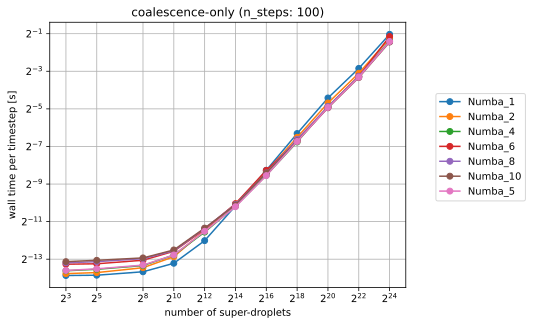

HTML(value="<a href='./tmpuuzoi0te.pdf' target='_blank'>./tmpuuzoi0te.pdf</a><br>")

In [57]:
plot_processed_results(coalescence_only_processed, plot_title=f'coalescence-only (n_steps: {n_steps})')

In [64]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}-coalescence-double.txt"
write_to_file(filename=filename, d=coalescence_only_processed)

### Benchmark Breakup-only

In [32]:
res_breakup_only = go_benchmark(setup_breakup_only_sim, n_sds, n_steps, seeds, numba_n_threads=numba_n_threads, backends=[CPU])


 before

Numba_1 8


 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]

Numba_1 32


 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [32.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [32.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [32.]

Numba_1 256


 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [256.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [256.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [256.]

Numba_1 1024


 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [1024.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [1024.]

 after
total_number [4.e+12]
total_volume

In [33]:
breakup_only_processed = process_results(res_breakup_only)

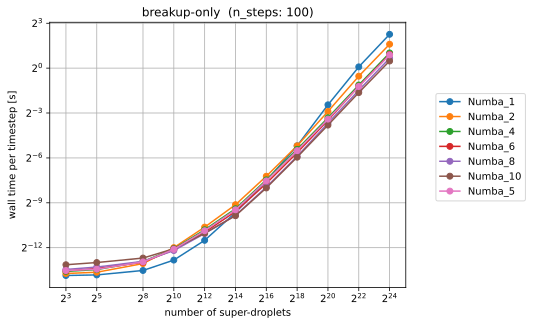

HTML(value="<a href='./tmpwy3aa0vb.pdf' target='_blank'>./tmpwy3aa0vb.pdf</a><br>")

In [56]:
plot_processed_results(breakup_only_processed, plot_title=f'breakup-only  (n_steps: {n_steps})')

In [65]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}-breakup-double.txt"
write_to_file(filename=filename, d=breakup_only_processed)

### Coalescence and Breakup

In [37]:
res_coal_breakup = go_benchmark(setup_coalescence_breakup_sim, n_sds, n_steps, seeds, numba_n_threads=numba_n_threads, backends=[CPU])


 before

Numba_1 8


 after
total_number [8698544.]
total_volume [1000000.]
super_particle_count [8.]

 after
total_number [4207135.]
total_volume [1000000.]
super_particle_count [8.]

 after
total_number [134281.]
total_volume [1000000.]
super_particle_count [8.]

Numba_1 32


 after
total_number [44694.]
total_volume [1000000.]
super_particle_count [32.]

 after
total_number [9.43785262e+10]
total_volume [1000000.]
super_particle_count [32.]

 after
total_number [51479.]
total_volume [1000000.]
super_particle_count [32.]

Numba_1 256


 after
total_number [12621938.]
total_volume [1000000.]
super_particle_count [256.]

 after
total_number [57171.]
total_volume [1000000.]
super_particle_count [256.]

 after
total_number [1.6143097e+09]
total_volume [1000000.]
super_particle_count [256.]

Numba_1 1024


 after
total_number [6.29140047e+09]
total_volume [1000000.]
super_particle_count [1022.]

 after
total_number [2.47492123e+09]
total_volume [1000000.]
super_particle_count [1020.]

 a

In [38]:
coal_breakup_processed = process_results(res_coal_breakup)

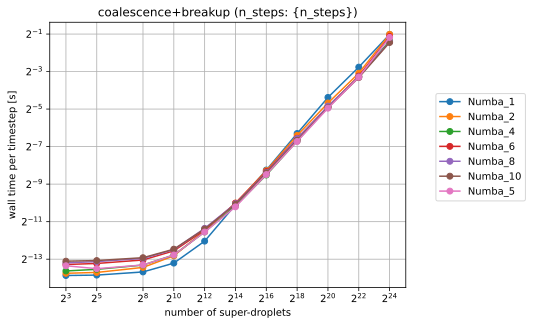

HTML(value="<a href='./tmpjlcq1sjt.pdf' target='_blank'>./tmpjlcq1sjt.pdf</a><br>")

In [55]:
plot_processed_results(coal_breakup_processed, plot_title='coalescence+breakup (n_steps: {n_steps})')

In [66]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}-coal+breakup-double.txt"
write_to_file(filename=filename, d=coal_breakup_processed)

## Write to file

In [ ]:
d = {'coalescence': coalescence_only_processed, 'breakup': breakup_only_processed, 'coalescence+breakup': coal_breakup_processed}

In [ ]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}"
write_to_file(filename=filename, d=d)



In [1]:
import numpy as np
import time

In [2]:
from numba import njit, prange
import numba
numba.get_num_threads()

8

In [81]:
@njit
def f(i, arr):
    for j in range(1_000):
        arr[i] /= 23423948129 * (j+1)
        arr[i] += j**12
        arr[i] -= 3737 * 787 * 28

In [86]:
N = 1600

def g_seq():
    arr = np.random.rand(N)

    for i in range(N):
        f(i, arr)

@njit(parallel=True)
def g_par():
    arr = np.random.rand(N)

    for i in prange(N):
        f(i, arr)

In [87]:
t0 = time.time()
g_seq()
t1 = time.time()
print('elapsed seq', t1-t0, 's')

t0 = time.time()
g_seq()
t1 = time.time()

seq_time = t1-t0

print('elapsed seq', seq_time, 's')



elapsed seq 0.018127918243408203 s
elapsed seq 0.014945030212402344 s


In [88]:
t0 = time.time()
g_par()
t1 = time.time()
print('elapsed par', t1-t0, 's')

t0 = time.time()
g_par()
t1 = time.time()

par_time = t1-t0
print('elapsed par', par_time, 's')



elapsed par 0.43813037872314453 s
elapsed par 0.0018100738525390625 s


In [89]:
seq_time / par_time

8.256585879873551